In [45]:
import tensorflow as tf
import os
import splitfolders as sf
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.schedules import CosineDecay
import math
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
from tensorflow.keras import layers, models
from tensorflow.python.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
train_dir = r'A:\AI DB\LSPD\images_pret\train'
validation_dir = r'A:\AI DB\LSPD\images_pret\val'
test_dir = r'A:\AI DB\LSPD\images_pret\test'

# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 256

In [18]:
# Define data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,                                          
    seed=10,
    class_mode='categorical'
)

Found 400000 images belonging to 5 classes.
Found 50000 images belonging to 5 classes.
Found 50000 images belonging to 5 classes.


In [19]:
# Define a cosine decay learning rate schedule with warmup
initial_learning_rate = 1e-1
total_epochs = 6
warmup_steps = int(0.1 * total_epochs * (train_generator.samples // train_generator.batch_size))

# Define a cosine decay learning rate schedule with warmup
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate,
                                                         decay_steps=warmup_steps,
                                                         alpha=0.01)

# Define the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [20]:
model_InceptionV3_pre_entrainer = tf.keras.applications.InceptionV3(
                        include_top = False, 
                        weights = 'imagenet',
                        input_shape = (img_height, img_width,3),
                        pooling = 'avg', 
                    )

for layer in model_InceptionV3_pre_entrainer.layers:
    layer.trainable = False

In [25]:
# Create a new Sequential model
modelInceptionV3 = Sequential([
    model_InceptionV3_pre_entrainer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # Output layer with 5 classes
])

# Compile the model with the optimizer
modelInceptionV3.compile(optimizer=optimizer,
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

In [26]:
modelInceptionV3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dense_9 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 22,854,437
Trainable params: 1,051,653
Non-trainable params: 21,802,784
_________________________________________________________________


In [27]:
checkpoint_filepath3 = r'A:\AI DB\LSPD\models\inceptionv3_lspd.keras'
model_checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')

In [28]:
history3 = modelInceptionV3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=model_checkpoint_callback3
)

Epoch 1/6
1562/1562 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.8587
Epoch 1: val_accuracy improved from -inf to 0.87634, saving model to A:\AI DB\LSPD\models\inceptionv3_lspd.keras
1562/1562 [==============================] - 6454s 4s/step - loss: 0.4319 - accuracy: 0.8587 - val_loss: 0.3446 - val_accuracy: 0.8763
Epoch 2/6
1562/1562 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.8786
Epoch 2: val_accuracy improved from 0.87634 to 0.88161, saving model to A:\AI DB\LSPD\models\inceptionv3_lspd.keras
1562/1562 [==============================] - 6438s 4s/step - loss: 0.3369 - accuracy: 0.8786 - val_loss: 0.3272 - val_accuracy: 0.8816
Epoch 3/6
1562/1562 [==============================] - ETA: 0s - loss: 0.3201 - accuracy: 0.8842
Epoch 3: val_accuracy did not improve from 0.88161
1562/1562 [==============================] - 6471s 4s/step - loss: 0.3201 - accuracy: 0.8842 - val_loss: 0.3265 - val_accuracy: 0.8815
Epoch 4/6
1562/1562 [===

In [29]:
ypred3=modelInceptionV3.predict(test_generator)

196/196 [==============================] - 751s 4s/step


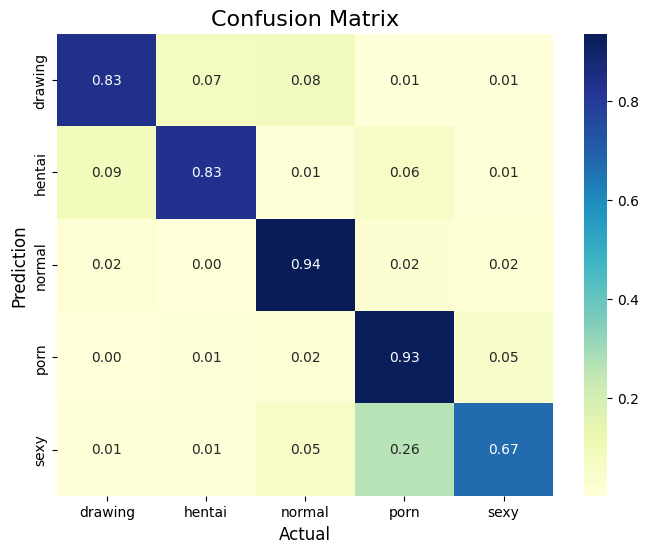

Accuracy: 0.8874
Precision: [0.84493927 0.88562925 0.92841089 0.90397592 0.72672283]
Recall: [0.8348     0.8332     0.93633333 0.93105    0.6728    ]
F1 Score: [0.83983903 0.858615   0.93235528 0.91731323 0.69872261]
Classification Report:
               precision    recall  f1-score   support

     drawing       0.84      0.83      0.84      5000
      hentai       0.89      0.83      0.86      5000
      normal       0.93      0.94      0.93     15000
        porn       0.90      0.93      0.92     20000
        sexy       0.73      0.67      0.70      5000

    accuracy                           0.89     50000
   macro avg       0.86      0.84      0.85     50000
weighted avg       0.89      0.89      0.89     50000



In [31]:
# Extract predicted classes from one-hot encoded format
y_pred_classes3 = np.argmax(ypred3, axis=1)

# Get actual classes
y_true_classes3 = test_generator.classes

# Create a confusion matrix
cm3 = confusion_matrix(y_true_classes3, y_pred_classes3)
cmn3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmn3, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Prediction', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show(block=False)

# Accuracy
accuracy3 = accuracy_score(y_true_classes3, y_pred_classes3)
print("Accuracy:", accuracy3)

# Precision
precision3 = precision_score(y_true_classes3, y_pred_classes3, average=None)
print("Precision:", precision3)

# Recall
recall3 = recall_score(y_true_classes3, y_pred_classes3, average=None)
print("Recall:", recall3)

# F1 score
f1_3 = f1_score(y_true_classes3, y_pred_classes3, average=None)
print("F1 Score:", f1_3)

# Classification Report
cr3 = classification_report(y_true_classes3, y_pred_classes3, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", cr3)

In [33]:
#data ogmontation
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,      
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 400000 images belonging to 5 classes.


In [34]:
modelInceptionV3Unfreeze=modelInceptionV3

In [37]:
for layer in model_InceptionV3_pre_entrainer.layers[-20:]:
    layer.trainable = True


modelInceptionV3Unfreeze.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

In [38]:
modelInceptionV3Unfreeze.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dense_9 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 22,854,437
Trainable params: 2,544,645
Non-trainable params: 20,309,792
_________________________________________________________________


In [39]:
checkpoint_filepath3unfrz = r'A:\AI DB\LSPD\models\inceptionv3_lspd_unfreeze.keras'
model_checkpoint_callback3unfrz = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath3unfrz,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')

In [40]:
history3unfrz = modelInceptionV3Unfreeze.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=model_checkpoint_callback3unfrz
)

Epoch 1/6
1562/1562 [==============================] - ETA: 0s - loss: 0.4098 - accuracy: 0.8548
Epoch 1: val_accuracy improved from -inf to 0.89157, saving model to A:\AI DB\LSPD\models\inceptionv3_lspd_unfreeze.keras
1562/1562 [==============================] - 9022s 6s/step - loss: 0.4098 - accuracy: 0.8548 - val_loss: 0.3008 - val_accuracy: 0.8916
Epoch 2/6
1562/1562 [==============================] - ETA: 0s - loss: 0.3322 - accuracy: 0.8792
Epoch 2: val_accuracy improved from 0.89157 to 0.89736, saving model to A:\AI DB\LSPD\models\inceptionv3_lspd_unfreeze.keras
1562/1562 [==============================] - 8959s 6s/step - loss: 0.3322 - accuracy: 0.8792 - val_loss: 0.2840 - val_accuracy: 0.8974
Epoch 3/6
1562/1562 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8832
Epoch 3: val_accuracy improved from 0.89736 to 0.89932, saving model to A:\AI DB\LSPD\models\inceptionv3_lspd_unfreeze.keras
1562/1562 [==============================] - 8966s 6s/step - loss: 

In [41]:
ypred3unfrz=modelInceptionV3Unfreeze.predict(test_generator)

196/196 [==============================] - 734s 4s/step


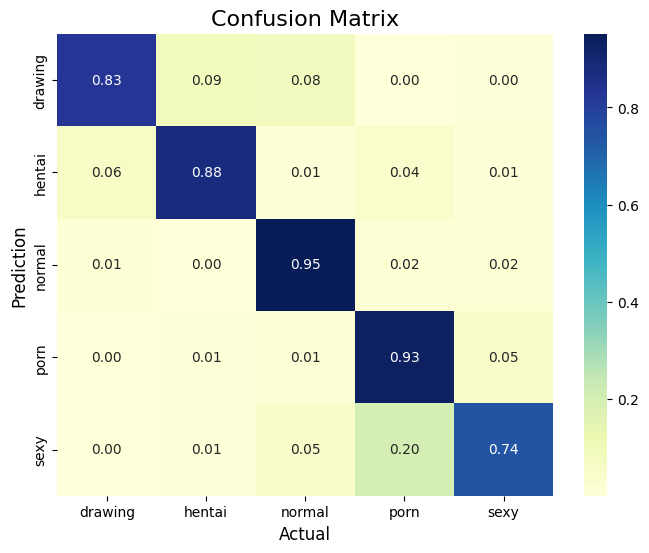

Accuracy: 0.90232
Precision: [0.89577465 0.8760479  0.93699961 0.92675635 0.73317545]
Recall: [0.8268     0.8778     0.95186667 0.93       0.743     ]
F1 Score: [0.8599064  0.87692308 0.94437463 0.92837534 0.73805503]
Classification Report:
               precision    recall  f1-score   support

     drawing       0.90      0.83      0.86      5000
      hentai       0.88      0.88      0.88      5000
      normal       0.94      0.95      0.94     15000
        porn       0.93      0.93      0.93     20000
        sexy       0.73      0.74      0.74      5000

    accuracy                           0.90     50000
   macro avg       0.87      0.87      0.87     50000
weighted avg       0.90      0.90      0.90     50000



In [42]:
# Extract predicted classes from one-hot encoded format
y_pred_classes4 = np.argmax(ypred3unfrz, axis=1)

# Get actual classes
y_true_classes3 = test_generator.classes

# Create a confusion matrix
cm4 = confusion_matrix(y_true_classes3, y_pred_classes4)
cmn4 = cm4.astype('float') / cm4.sum(axis=1)[:, np.newaxis]
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmn4, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Prediction', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show(block=False)

# Accuracy
accuracy4 = accuracy_score(y_true_classes3, y_pred_classes4)
print("Accuracy:", accuracy4)

# Precision
precision4 = precision_score(y_true_classes3, y_pred_classes4, average=None)
print("Precision:", precision4)

# Recall
recall4 = recall_score(y_true_classes3, y_pred_classes4, average=None)
print("Recall:", recall4)

# F1 score
f1_4 = f1_score(y_true_classes3, y_pred_classes4, average=None)
print("F1 Score:", f1_4)

# Classification Report
cr4 = classification_report(y_true_classes3, y_pred_classes4, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", cr4)

In [43]:
epochs_trained = len(history3unfrz.history['loss'])
print("Epochs trained:", epochs_trained)

Epochs trained: 6


In [50]:
# Compute class weights
class_weights = compute_class_weight(class_weight = 'balanced',classes =  np.unique(train_generator.classes), y = train_generator.classes)

# Convert class weights to a dictionary format
class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))

In [58]:
checkpoint_filepath3unfrz = r'A:\AI DB\LSPD\models\inceptionv3_lspd_unfreezeBalanced.keras'
model_checkpoint_callback3unfrz = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath3unfrz,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')

In [59]:
history3unfrz = modelInceptionV3Unfreeze.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=12,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    initial_epoch=5,
    class_weight=class_weights_dict,
    callbacks=model_checkpoint_callback3unfrz
)

Epoch 6/12
1562/1562 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8711
Epoch 6: val_accuracy improved from -inf to 0.88532, saving model to A:\AI DB\LSPD\models\inceptionv3_lspd_unfreezeBalanced.keras
1562/1562 [==============================] - 9122s 6s/step - loss: 0.3555 - accuracy: 0.8711 - val_loss: 0.3117 - val_accuracy: 0.8853
Epoch 7/12
1562/1562 [==============================] - ETA: 0s - loss: 0.3476 - accuracy: 0.8716
Epoch 7: val_accuracy did not improve from 0.88532
1562/1562 [==============================] - 8949s 6s/step - loss: 0.3476 - accuracy: 0.8716 - val_loss: 0.3213 - val_accuracy: 0.8809
Epoch 8/12
1562/1562 [==============================] - ETA: 0s - loss: 0.3442 - accuracy: 0.8724
Epoch 8: val_accuracy did not improve from 0.88532
1562/1562 [==============================] - 8880s 6s/step - loss: 0.3442 - accuracy: 0.8724 - val_loss: 0.3138 - val_accuracy: 0.8836
Epoch 9/12
1562/1562 [==============================] - ETA: 0s - los

KeyboardInterrupt: 

In [60]:
modelunfrzunblcd=tf.keras.models.load_model(checkpoint_filepath3unfrz)
modelunfrzunblcd.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dense_9 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 22,854,437
Trainable params: 2,544,645
Non-trainable params: 20,309,792
_________________________________________________________________


In [61]:
ypred3unfrzblcd=modelunfrzunblcd.predict(test_generator)

196/196 [==============================] - 733s 4s/step


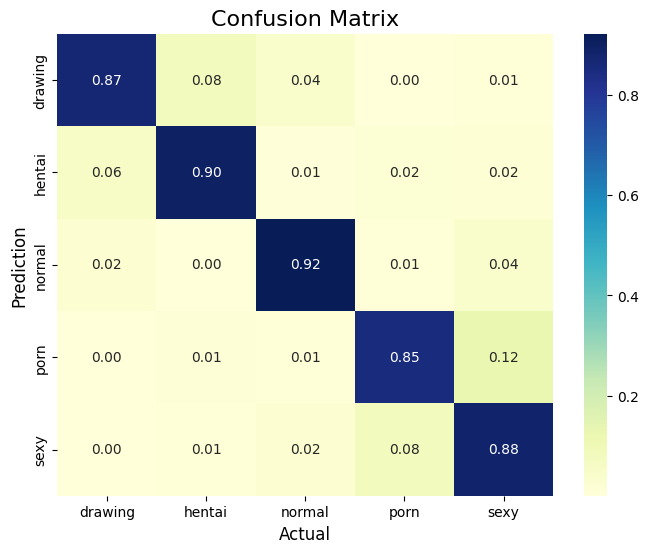

Accuracy: 0.8825
Precision: [0.86329365 0.85455585 0.96260966 0.96149292 0.5793828 ]
Recall: [0.8702     0.8966     0.92166667 0.8527     0.8824    ]
F1 Score: [0.86673307 0.8750732  0.94169335 0.90383443 0.69948474]
Classification Report:
               precision    recall  f1-score   support

     drawing       0.86      0.87      0.87      5000
      hentai       0.85      0.90      0.88      5000
      normal       0.96      0.92      0.94     15000
        porn       0.96      0.85      0.90     20000
        sexy       0.58      0.88      0.70      5000

    accuracy                           0.88     50000
   macro avg       0.84      0.88      0.86     50000
weighted avg       0.90      0.88      0.89     50000



In [62]:
# Extract predicted classes from one-hot encoded format
y_pred_classes4 = np.argmax(ypred3unfrzblcd, axis=1)

# Get actual classes
y_true_classes3 = test_generator.classes

# Create a confusion matrix
cm4 = confusion_matrix(y_true_classes3, y_pred_classes4)
cmn4 = cm4.astype('float') / cm4.sum(axis=1)[:, np.newaxis]
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmn4, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Prediction', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show(block=False)

# Accuracy
accuracy4 = accuracy_score(y_true_classes3, y_pred_classes4)
print("Accuracy:", accuracy4)

# Precision
precision4 = precision_score(y_true_classes3, y_pred_classes4, average=None)
print("Precision:", precision4)

# Recall
recall4 = recall_score(y_true_classes3, y_pred_classes4, average=None)
print("Recall:", recall4)

# F1 score
f1_4 = f1_score(y_true_classes3, y_pred_classes4, average=None)
print("F1 Score:", f1_4)

# Classification Report
cr4 = classification_report(y_true_classes3, y_pred_classes4, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", cr4)